# Introduction to Policy Gradients

Authors: Sean Lin, Jaiveer Singh, Ethan Mehta

Estimated Time: 1 hr. 30 min.

References: 

- OpenAI Spinning Up (https://spinningup.openai.com/en/latest/index.html)
<br> OpenAI's open source resource on reinforcement learning, Spinning Up, provides utils files and skeleton code for vanilla policy gradients that we built upon for this assignment

- EECS 16A Segway Tours Problem: https://eecs16a.org/homework/prob4.pdf

- Vanilla Policy Gradients: https://medium.com/@aniket.tcdav/vanilla-policy-gradient-with-tensorflow-2-9855df271472, https://www.janisklaise.com/post/rl-policy-gradients/

## Introduction

Recall the classic EECS 16AB self-balancing segway problem. The segway problem is used as a means to develop fundamental understanding of control theory and linear algebra. Interestingly, we can use reinforcement learning methods to teach a segway how to self-balance! In the previous walkthrough assignment, you were introduced to the fundamental concepts of reinforcement of learning: actions, states, policies, and rewards. This assignment will use the segway problem as a means to introduce students to reinforcement learning, policy gradients as a means of optimizing policies, and deep RL.

<img src="images/segway.png">

## Setup

We have prepared a conda environment for you to work on this assignment, since this assignment uses packages such as tensorflow, numpy, and OpenAI gym that may cause problems if the versions are incompatible and different. Follow the following steps to set up the environment:

1) In this problem's, you should see an environment.yml file.
<br> 2) Create a new conda environment named spinningup by running `conda env create --file environment.yaml`
<br> 3) Run `conda activate spinningup` to activate the environment
<br> 4) Run `python -m ipykernel install --user --name=spinningup` to export this environment into an iPython notebook kernel so that we can use it in this notebook.
<br> 5) Restart the jupyter notebook. In the menu, go to `Kernel -> Change Kernel`. You should see an environment named `spinningup` among the list of kernels. Switch your kernel to `spinningup`, and now you are all set!
<br>
<img src='images/kernel_change.png' width="909" height="500">
</br>
<br> 6) Run the imports below

In [2]:
import numpy as np
import tensorflow as tf
import gym
from gym.wrappers.monitor import Monitor, load_results
import matplotlib.pyplot as plt
import time
import core
import vpg
from utils.logx import EpochLogger
from utils.mpi_tf import MpiAdamOptimizer, sync_all_params
from utils.mpi_tools import mpi_fork, mpi_avg, proc_id, mpi_statistics_scalar, num_procs
from utils.run_utils import setup_logger_kwargs

<b> Note:</b> Because machine learning, and specifically deep reinforcement learning, is still a relatively nascent field, many machine-learning libraries are fragile and require dependencies that may easily become deprecated (i.e. tensorflow 1.15 vs. tensorflow 2.0). To reproduce machine learning experiments and projects, it is paramount that one knows how to freeze and export an environment for later usage as we did for you in this assignment. We recommend that all students taking EECS 16ML be well-versed in this practice.

## Training a Segway to Stand Upright

In the segway problem, the segway can move anywhere on the line, and lean in any way. Therefore, we can define the state of the world as the following: 
$$[\text{position of cart}, \text{velocity of cart}, \text{angle of pole}, \text{rotation rate of pole}]$$

The actions that the segway can take to change its state are to 1) lean left and 2) lean right.
We can imagine the reward as the amount of time that the segway stays upright without falling down. Now, we just need to determine a policy such that the segway can take the optimal actions, given the state, to maximize the reward.

As always, let's start with a simple example. We will program an agent that uses a logistic policy to linearly classify our decision to either lean left or right.

### Task 1: Implement the gradient ascent step for a basic policy

Below, we define the `LogisticPolicy` class. Most of the code is already implemented for you, including the code to calculate the reward and the gradient of the log likelihood. Your task is to implement the gradient ascent step in the `update` function of the class. Recall that the gradient ascent step is defined as the following:

$$\theta_{t+1} = \theta_t + \alpha *(E_\theta[\sum_{t=1}^T \nabla_\theta \log P(s_{t+1} | s_t, a_t) R(\tau)])$$

The reward is calculated in `discount_rewards` and the gradient of the log likelihood is calculated in `grad_log_p`. Fill in the code for `update` to complete gradient ascent.

In [3]:
class LogisticPolicy:

    def __init__(self, theta, alpha, gamma):
        # Initialize paramters θ, learning rate α and discount factor γ

        self.theta = theta
        self.alpha = alpha
        self.gamma = gamma

    def logistic(self, y):
        # definition of logistic function

        return 1/(1 + np.exp(-y))

    def probs(self, x):
        # returns probabilities of two actions

        y = x @ self.theta
        prob0 = self.logistic(y)

        return np.array([prob0, 1-prob0])

    def get_action(self, x):
        # sample an action in proportion to probabilities

        probs = self.probs(x)
        action = np.random.choice([0, 1], p=probs)

        return action, probs[action]

    def grad_log_p(self, x):
        # calculate grad-log-probs

        y = x @ self.theta
        grad_log_p0 = x - x*self.logistic(y)
        grad_log_p1 = - x*self.logistic(y)

        return grad_log_p0, grad_log_p1

    def discount_rewards(self, rewards):
        # calculate discounted rewards

        discounted_rewards = np.zeros(len(rewards))
        cumulative_rewards = 0
        for i in reversed(range(0, len(rewards))):
            cumulative_rewards = cumulative_rewards * self.gamma + rewards[i]
            discounted_rewards[i] = cumulative_rewards

        return discounted_rewards

    def update(self, rewards, obs, actions):
        # calculate gradients for each action over all observations
        grad_log_p = np.array([self.grad_log_p(ob)[action] for ob,action in zip(obs,actions)])

        assert grad_log_p.shape == (len(obs), 4)

        # calculate the rewards earned for a specific trajectory of actions
        discounted_rewards = self.discount_rewards(rewards)
        
        ### SOLUTION ###
        dot = grad_log_p.T @ discounted_rewards

        self.theta += self.alpha*dot
        ### END ###

### Task 2: Implement the train step of the reinforcement learning trainer

Now, we will implement the model trainer, which will iterate through the data and optimize our policy. Below, we define the `RLTrainer` class. Most of the code is already implemented for you; all you have to do is fill in the code inside of the `train` loop. The loop should do three things:
1) Run an episode (simulation) of the segway world given the current policy<br>
2) Append the total reward computed from the episode to the list `episode_rewards` for future graphical analysis<br>
3) Update the model policy given the rewards, observations, and actions

In [4]:
class RLTrainer:
    
    def __init__(self, policy):
        self.policy = policy
        self.env = gym.make('CartPole-v0')
        
    def run_episode(self, model_policy, render=True):

        observation = self.env.reset()
        totalreward = 0

        observations = []
        actions = []
        rewards = []
        probs = []

        done = False

        while not done:
            if render:
                self.env.render()

            observations.append(observation)

            action, prob = model_policy.get_action(observation)
            observation, reward, done, info = self.env.step(action)

            totalreward += reward
            rewards.append(reward)
            actions.append(action)
            probs.append(prob)

        return totalreward, np.array(rewards), np.array(observations), np.array(actions), np.array(probs)
    
    def train(self, theta, alpha, gamma, MAX_EPISODES=1000, seed=np.random.seed(0)):
        # Initialize variables
        episode_rewards = []
        model_policy = self.policy(theta, alpha, gamma)

        # train until MAX_EPISODES
        for i in range(MAX_EPISODES):
            
            ### SOLUTION ###
            total_reward, rewards, observations, actions, probs = self.run_episode(model_policy)
            episode_rewards.append(total_reward)
            model_policy.update(rewards, observations, actions)
            ### END ###
            
            print("EP: " + str(i) + " Score: " + str(total_reward) + " ",end="\r", flush=False)
        self.env.close()
        return episode_rewards, model_policy

Now that we have implemented the model policy and trainer, run the code block below to watch our segway learn to stand upright! We train with a learning rate of 0.002, gamma of 0.99, and 300 episodes.

A reward of 200 means that the segway successfully learned how to stand upright for a substantial period of time, and thus completed its challenge!

Answer the following questions:

1) Around how many episodes does it take for the CartPole to complete the challenge?
<br> <i> Answer: </i>


2) What do you notice about the CartPole as it is training? Describe its improvement over time.
<br> <i> Answer: </i>

/Users/seanlin/opt/anaconda3/envs/spinningup/lib/python3.6/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


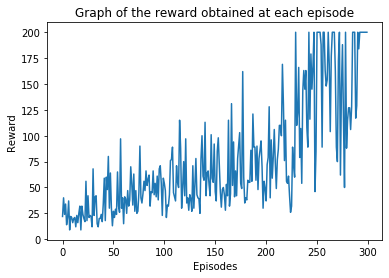

In [5]:
trainer = RLTrainer(LogisticPolicy)

episode_rewards, policy = trainer.train(theta=np.random.rand(4),
                                alpha=0.002,
                                gamma=0.99,
                                MAX_EPISODES=300)
plt.plot(episode_rewards)
plt.title("Graph of the reward obtained at each episode")
plt.xlabel("Episodes")
plt.ylabel("Reward")
plt.show()

## Advanced Policies: Intro to Deep RL

In the previous section, we used a logistic policy as a means to teach our segway to stand upright. While the segway did imporve and eventually complete the challenge, you probably noticed that its performance fluctuated: on one episode it may complete the challenge, and on the next episode it may completely fail! 

Perhaps we can develop a more sophisticated policy to further improve our segway's performance? This is where neural networks come in handy. Given observations as input, we can develop a classification neural network that outputs the probabilities that we pick an action. Given these probabilities, we then sample from a multinomial distribution defined by these probabilities to pick what action to take.

In the case of the CartPole, we have two actions that we can take: move left or move right. After feeding our observational data into our neural network. We do some processing to obtain the probabilities of moving left ($p_l$) and right ($p_r$) respectively. Since we have two actions, we can use a $binomial(p_l)$ distribution to sample for which action to take! In the following exercises, we will implement such a categorical policy using TensorFlow.


<img src="images/policy_nn.png" width="576" height="300">

### Task 3: Implement Multilayer Perceptron

In this task, we will define a categorical policy computed via a multilayer perceptron. 

First, fill in the function `mlp`. `mlp` builds a multilayer perceptron. It takes in as parameter layers, which specifies the number of units per layer in the multilayer perceptron (i.e. if layers=[64,64,2], we have 2 fully connected layers of 64 units, and an output layer of 2 units). It also takes in x, the input tensor, and activation functions that are necessary for the construction of the neural network.

Hint: You my find the function `tf.layers.dense` helpful.



In [6]:
def mlp(x, layers=[64,64,2], activation=tf.tanh, output_activation=None):
    """
    Builds a multi-layer perceptron in Tensorflow.

    Args:
        x: Input tensor.

        layers: Tuple, list, or other iterable giving the number of units
            for each layer of the MLP.

        activation: Activation function for all layers except last.

        output_activation: Activation function for last layer.

    Returns:
        A TF symbol for the output of an MLP that takes x as an input.

    """
    
    ### SOLUTION ###
    for layer in layers[:-1]:
        x = tf.layers.dense(x, units=layer, activation=activation)
    return tf.layers.dense(x, units=layers[-1], activation=output_activation)
    ### END ###

### Task 4: Implement Categorical Policy

Now that we have a multilayer perceptron that can take in observations as input and compute the log-odds (logits) of our two actions, we want to define a categorical policy that makes use of this MLP to determine our action. Follow the following steps to implement our categorical policy:

1) Call `mlp` on the appropriate arguments to obtain a tensor of logits (log-odds) for our actions. Logits are defined as follows:

$$logit(p_a) = \log{\frac{p_a}{1-p_a}}$$

where $p$ is defined as the probability of taking action $a$.

2) To convert logits to probabilities, we can take a softmax of the logits. For an action a, the softmax is defined as follows: 

$$ Softmax(a) = \frac{e^{l_a}}{\sum_{a' \in A} e^{l_a'}} $$

where $l_a$ is the logit for action $a$, and $A$ is the set of all actions.
<br>In this case, we want to take the log of the softmax because it is easier to compute gradients with log softmaxes. 

3) Sample from a multinomial distribution to obtain our action.

<b> Hint 1: </b> Read up on the functions `tf.nn.log_softmax` and `tf.multinomial`
<br><b> Hint 2: </b> The number of actions that we can take is represented as `action_space.n`

In [7]:
def mlp_categorical_policy(x, a, nn_sizes, activation, output_activation, action_space):
    """
    Builds TF symbols to sample actions and compute log-probabilities of those actions.

    Args:
        x: Input tensor of states. Shape [batch, obs_dim].

        a: Input tensor of actions. Shape [batch, act_dim].

        nn_sizes: Sizes of the layers for action network MLP, excluding the output layer.

        activation: Activation function for all layers except last.

        output_activation: Activation function for last layer (action layer).

        action_space: A gym.spaces object describing the action space of the
            environment this agent will interact with.

    Returns:
        pi: A symbol for sampling stochastic actions from a multinomial distribution

        logp: A symbol for computing log-likelihoods of actions from a multinomial distribution.

        logp_pi: A symbol for computing log-likelihoods of actions in pi from a multinomial distribution

    """
    
    ### SOLUTION ###
    act_dim = action_space.n
    logits = mlp(x, list(nn_sizes)+[act_dim], activation, None)
    logp_all = tf.nn.log_softmax(logits)
    sample = tf.multinomial(logits,1)
    ### END ###
    pi = tf.squeeze(sample, axis=1)
    logp = tf.reduce_sum(tf.one_hot(a, depth=act_dim) * logp_all, axis=1)
    logp_pi = tf.reduce_sum(tf.one_hot(pi, depth=act_dim) * logp_all, axis=1)
    return pi, logp, logp_pi

### Task 5: Run the Segway Experiment again!

Below is the starter code to run the CartPole experiment with our more powerful model using a neural network policy. We use an algorithm called Vanilla Policy Gradient (VPG) that takes in your categorical policy and trains on the segway problem. All that is left to do is initialize some of the experiment parameters. We want our categorical policy to be a 3 layer neural network. The first two layers consist of 64 units. Given this information, fill in `nn_units` and `depth` accordingly. Remember that the last layer of the neural network is not defined here, but in the `mlp_categorical_policy` function that you wrote above.

Train for 100 epochs and 4000 steps per epoch. The model should take roughly 20-30 min. to train. As you train your RL model, you will be able to see the cartpole training. Pay attention to the metric AverageEpRet––this is the average reward that your model achieved in the epoch. If your code was implemented correctly, AverageEpRet should achieve scores of roughly 200 or higher in the last 10 epochs.

Answer the following questions:

1) What is the AverageEpRet of your model in the final 10 epochs? 
<br> <i> Answer: </i>


2) What do you notice about the CartPole as it is training? Describe its improvement over time.
<br> <i> Answer: </i>

In [ ]:
env = 'CartPole-v1'

### SOLUTION ###
nn_units = 64
depth = 2
steps = 4000
epochs = 100
### END ###
gamma = 0.99
seed = 0
# parser.add_argument('--cpu', type=int, default=2)
exp_name = 'vpg'

# Reset the default graph to prevent errors on multiple runs of Vanilla Policy Gradient
tf.reset_default_graph()
logger_kwargs = setup_logger_kwargs(exp_name, seed)

vpg.run(lambda : gym.make(env), actor_critic=core.mlp_actor_critic,
    ac_kwargs=dict(policy=mlp_categorical_policy, nn_sizes=[nn_units]*depth), gamma=gamma, 
    seed=seed, steps_per_epoch=steps, epochs=epochs,
    logger_kwargs=logger_kwargs)

Logging data to /Users/seanlin/Desktop/MehtaKnights-189/prob2/data/vpg/vpg_s0/progress.txt
Saving config:

{
    "ac_kwargs":	{
        "nn_sizes":	[
            64,
            64
        ],
        "policy":	"mlp_categorical_policy"
    },
    "actor_critic":	"mlp_actor_critic",
    "env_fn":	"<function <lambda> at 0x145e31c80>",
    "epochs":	100,
    "exp_name":	"vpg",
    "gamma":	0.99,
    "lam":	0.97,
    "logger":	{
        "<utils.logx.EpochLogger object at 0x133db9668>":	{
            "epoch_dict":	{},
            "exp_name":	"vpg",
            "first_row":	true,
            "log_current_row":	{},
            "log_headers":	[],
            "output_dir":	"/Users/seanlin/Desktop/MehtaKnights-189/prob2/data/vpg/vpg_s0",
            "output_file":	{
                "<_io.TextIOWrapper name='/Users/seanlin/Desktop/MehtaKnights-189/prob2/data/vpg/vpg_s0/progress.txt' mode='w' encoding='UTF-8'>":	{
                    "mode":	"w"
                }
            }
        }
    },
    

### You're done! Isn't it cool what reinforcement learning can do?